In [1]:
import geopandas as gpd
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.datasets import make_blobs
from tqdm import tqdm

import prospect

sns.set()
sns.set_style("ticks")
np.random.RandomState(5)

RandomState(MT19937) at 0x12758FC00

In [76]:
# A simple square area of 1 million square units
# If the units are meters, this would be equivalent to a 1km x 1km area
area = prospect.Area.from_area_value(name="area", value=1000000, origin=(0, 0), vis=1.0)

# Create one perfect surveyor and assign them to a team
surveyor = prospect.Surveyor(name="surveyor", team_name="team", surveyor_type="perfect", skill=1.0, speed_penalty=0.0)
team = prospect.Team(name="team", surveyor_list=[surveyor], assignment="naive")

# Create a bunch of transect Coverage configurations
spacings = [10, 20]
sweep_widths = [2, 4]
orientations = [0.0, 45.0, 90.0]

coverage_param_sets = itertools.product(*[spacings, sweep_widths, orientations])
coverages = []

for spacing, sweep_width, orientation in coverage_param_sets:
    coverage = prospect.Coverage.from_transects(
        name=f"coverage_{spacing}_{sweep_width}_{orientation}",
        area=area,
        spacing=spacing,
        sweep_width=sweep_width,
        orientation=orientation, 
        min_time_per_unit=1,
    )

    coverages.append(coverage)

surveys = {}

for i in tqdm(range(50)):  # run all Coverages with 50 different Assemblages
    # Make random point clusters
    # Set box to slightly less than Area to help ensure all points are within Area
    points, clusters = make_blobs(n_samples=40, centers=5, cluster_std=20, center_box=(50, 950))
    assert points.min() > 0, "Some points generated outside of Area"
    assert points.max() < 1000, "Some points generated outside of Area"   

    geo_points = gpd.points_from_xy(points.T[0], points.T[1])  # convert to shapely Points
    point_features = []  # list to store Features
    for idx, point in enumerate(geo_points):
        # create Feature objects from shapely Points
        feature = prospect.Feature(name=f"assemblage_{i}_point_{idx}_cluster_{clusters[idx]}", layer_name="sparse_clusters", shape=point, time_penalty=10.0)
        point_features.append(feature)

    # Make Layer from Feature objects
    sparse_layer = prospect.Layer(name="sparse_layer", area=area, assemblage_name="sparse_assemblage", input_features=point_features)
    sparse_layer.df["cluster"] = clusters  # add an arbitrary column to keep track of cluster
    sparse_assemblage = prospect.Assemblage(name=f"sparse_assemblage_{i}", area_name="area", layer_list=[sparse_layer])
    if sparse_assemblage.df.shape[0] != 40:
        print(sparse_assemblage.df.shape)
    
    for coverage in coverages:
        survey_name = f"survey_{i}_{coverage.name}"
        survey = prospect.Survey(name=survey_name, area=area, assemblage=sparse_assemblage, coverage=coverage, team=team)
        survey.run(n_runs=1)

        surveys[survey_name] = survey

100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


In [77]:
discovery_dfs = []  # collect all survey outputs with new metadata added
time_dfs = []
for _, s in surveys.items():
    # if s.assemblage.df.shape[0] != 40:
    #     print(s.assemblage.df.shape)
    if s.discovery.shape[0] != 40:
        print(s.discovery.shape)
    # Get some information about each artifact from the feature name
    parsed_feature_name = s.discovery["feature_name"].str.split("_", expand=True)
    

    # An ID for the assemblage it belongs to
    s.discovery["assemblage_config_id"] = parsed_feature_name[1]
    s.time_surveyunit["assemblage_config_id"] = parsed_feature_name[1]

    # An ID for the cluster it belongs to
    cluster_map = {str(i): char for i, char in enumerate("ABCDE")}
    s.discovery["cluster_id"] = (
        parsed_feature_name[5]
        .map(cluster_map)
    )

    # Some coverage-level metadata applied to all artifacts in the survey
    parsed_coverage_name = s.coverage.name.split("_")
    s.discovery["coverage_config_id"] = s.coverage.name.replace("coverage_", "")
    s.time_surveyunit["coverage_config_id"] = s.coverage.name.replace("coverage_", "")
    s.discovery["transect_spacing"] = parsed_coverage_name[1]
    s.discovery["sweep_width"] = parsed_coverage_name[2]
    s.discovery["transect_orientation"] = parsed_coverage_name[3]
    
    discovery_dfs.append(s.discovery)
    time_dfs.append(s.time_surveyunit)

# Make into one big DataFrame
all_results = pd.concat(discovery_dfs)
all_times = pd.concat(time_dfs)

In [78]:
mean_time = all_times.groupby(["coverage_config_id"]).agg(mean_time = pd.NamedAgg("total_time_per_surveyunit", "sum")).apply(lambda x: x / 50)

In [51]:
all_times.sort_values(by="total_time_per_surveyunit")

,run,surveyunit_name,surveyor_name,base_search_time,sum_time_penalty_obs,speed_penalty_obs,total_time_per_surveyunit,assemblage_config_id,coverage_config_id
18,0,coverage_10_4_45.0_77,surveyor,134.213562,10.0,0.0,144.213562,0,10_4_45.0
19,0,coverage_10_4_45.0_78,surveyor,154.213562,5.0,0.0,159.213562,0,10_4_45.0
2,0,coverage_20_4_45.0_3,surveyor,154.213562,5.0,0.0,159.213562,0,20_4_45.0
18,0,coverage_10_4_45.0_63,surveyor,174.213562,5.0,0.0,179.213562,46,10_4_45.0
19,0,coverage_10_4_45.0_62,surveyor,194.213562,5.0,0.0,199.213562,10,10_4_45.0
...,...,...,...,...,...,...,...,...,...
0,0,coverage_10_4_45.0_1,surveyor,1414.213562,10.0,0.0,1424.213562,0,10_4_45.0
0,0,coverage_10_4_45.0_1,surveyor,1414.213562,10.0,0.0,1424.213562,48,10_4_45.0
0,0,coverage_10_4_45.0_1,surveyor,1414.213562,15.0,0.0,1429.213562,43,10_4_45.0
0,0,coverage_10_4_45.0_1,surveyor,1414.213562,15.0,0.0,1429.213562,33,10_4_45.0


In [37]:
all_results.head()

,run,feature_name,shape,obs_rate,vis_obs,proximity_obs,skill_obs,discovery_prob,assemblage_config_id,cluster_id,coverage_config_id,transect_spacing,sweep_width,transect_orientation
0,0,assemblage_0_point_0_cluster_0,POINT (476.355 372.644),1.0,1.0,0.0,NaN,NaN,0,A,10_2_0.0,10,2,0.0
1,0,assemblage_0_point_1_cluster_0,POINT (477.417 383.347),1.0,1.0,0.0,NaN,NaN,0,A,10_2_0.0,10,2,0.0
2,0,assemblage_0_point_2_cluster_2,POINT (355.734 346.255),1.0,1.0,0.0,NaN,NaN,0,C,10_2_0.0,10,2,0.0
3,0,assemblage_0_point_3_cluster_4,POINT (887.939 156.730),1.0,1.0,0.0,NaN,NaN,0,E,10_2_0.0,10,2,0.0
4,0,assemblage_0_point_4_cluster_4,POINT (873.919 174.175),1.0,1.0,0.0,NaN,NaN,0,E,10_2_0.0,10,2,0.0


- How many clusters had at least one member detected?
- What is the percentage of each cluster that was detected?
- How many clusters were detected? (Run DBSCAN to try to reconstruct?)
- Are there artifacts that don't appear to be part of a cluster? This could indicate that our transects aren't capturing full patterns.
- Can I make a plot of time vs. <some discovery metric> to optimize?

- How many of the 40 artifacts were discovered?
- How many clusters had at least one member detected? 
- How many clusters had zero members detected?
- How many clusters had all members detected?
- What fraction of each cluster was detected?
- If we didn’t know the number of input clusters, how many clusters would a typical clustering algorithm detect and how different is that from the five clusters we know were there originally?

In [11]:
configs_clusters = all_results.groupby(["coverage_config_id", "assemblage_config_id", "cluster_id"]).agg(discovered = pd.NamedAgg("discovery_prob", "sum"))

In [12]:
configs_clusters

discovered
coverage_config_id assemblage_config_id cluster_id            
10_2_0.0           0                    A                  4.0
                                        B                  3.0
                                        C                  1.0
                                        D                  4.0
                                        E                  4.0
...                                                        ...
5_2_90.0           9                    A                  7.0
                                        B                  6.0
                                        C                  6.0
                                        D                  8.0
                                        E                  6.0

[2250 rows x 1 columns]

## For each Coverage configuration... 

### What percent of artifacts were discovered?

In [42]:
all_results.head()

,run,feature_name,shape,obs_rate,vis_obs,proximity_obs,skill_obs,discovery_prob,assemblage_config_id,cluster_id,coverage_config_id,transect_spacing,sweep_width,transect_orientation
0,0,assemblage_0_point_0_cluster_0,POINT (476.355 372.644),1.0,1.0,0.0,NaN,NaN,0,A,10_2_0.0,10,2,0.0
1,0,assemblage_0_point_1_cluster_0,POINT (477.417 383.347),1.0,1.0,0.0,NaN,NaN,0,A,10_2_0.0,10,2,0.0
2,0,assemblage_0_point_2_cluster_2,POINT (355.734 346.255),1.0,1.0,0.0,NaN,NaN,0,C,10_2_0.0,10,2,0.0
3,0,assemblage_0_point_3_cluster_4,POINT (887.939 156.730),1.0,1.0,0.0,NaN,NaN,0,E,10_2_0.0,10,2,0.0
4,0,assemblage_0_point_4_cluster_4,POINT (873.919 174.175),1.0,1.0,0.0,NaN,NaN,0,E,10_2_0.0,10,2,0.0


In [79]:
discovered_pct = all_results.groupby(["coverage_config_id"]).agg(discovered_pct = pd.NamedAgg("discovery_prob", "sum")).apply(lambda x: 100 * x / 4000).sort_values(by="discovered_pct")

- How many clusters had at least one member detected? 
- How many clusters had zero members detected?
- How many clusters had all members detected?
- What fraction of each cluster was detected?


In [80]:
discovery_time = discovered_pct.merge(mean_time, how="inner", left_index=True, right_index=True)
discovery_time.head()

,discovered_pct,mean_time
coverage_config_id,,
20_2_90.0,10.075,6580.600000
20_2_0.0,10.125,6361.000000
20_2_45.0,11.025,7038.336495
10_2_90.0,19.425,12735.400000
10_2_0.0,19.500,12436.000000


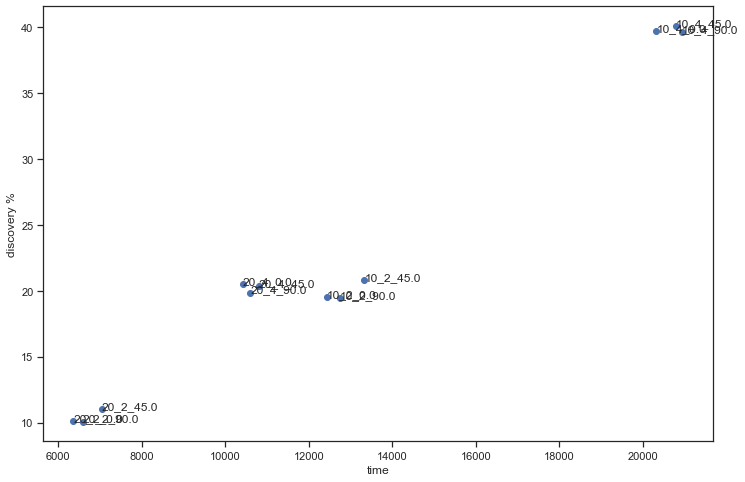

In [82]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(discovery_time["mean_time"], discovery_time["discovered_pct"])
ax.set_xlabel("time")
ax.set_ylabel("discovery %")
for i, txt in enumerate(discovery_time.index.values):
    ax.annotate(txt, (discovery_time["mean_time"][i], discovery_time["discovered_pct"][i]))

In [70]:
# 50 x 5 = 250 clusters per coverage_config_id
discovered_artifacts = all_results.loc[all_results["discovery_prob"].notna(), :]


# discovered_artifacts.groupby(["coverage_config_id", "assemblage_config_id"]).agg(clusters_discovered = pd.NamedAgg("cluster_id", "nunique")).sort_values(by="clusters_discovered")

In [ ]:
[k for k, val in surveys.items() if "5_5_90.0" in k]

In [ ]:
print(s.name.split("_"))
s.discovery.groupby("cluster").agg(discovered = pd.NamedAgg("discovery_prob", "sum"))

In [ ]:
# Make random point clusters
# Set box to slightly less than Area to help ensure all points are within Area
points, clusters = make_blobs(n_samples=40, centers=5, cluster_std=20, center_box=(25, 975))    

geo_points = gpd.points_from_xy(points.T[0], points.T[1])  # convert to shapely Points
point_features = []  # list to store Features
for idx, point in enumerate(geo_points):
    # create Feature objects from shapely Points
    feature = prospect.Feature(name=f"point_{idx}_cluster_{clusters[idx]}", layer_name="sparse_clusters", shape=point)
    point_features.append(feature)

# Make Layer from Feature objects
sparse_layer = prospect.Layer(name="sparse_layer", area=area, assemblage_name="sparse_assemblage", input_features=point_features)
sparse_layer.df["cluster"] = clusters  # add an arbitrary column to keep track of cluster
sparse_assemblage = prospect.Assemblage(name="sparse_assemblage", area_name="area", layer_list=[sparse_layer])

In [ ]:
sparse_assemblage.df.head()

In [ ]:
# parent_rates = [0.00001, 0.00005]
# max_child_rates = [12, 25]
# gaussian_variances = [10, 25, 50]

# assemblage_param_sets = itertools.product(*[parent_rates, max_child_rates, gaussian_variances])

# assemblages = []

# for parent_rate, max_child_rate, gaussian_variance in assemblage_param_sets:
#     class_a_layer = prospect.Layer.from_thomas_points(
#         parent_rate=parent_rate,
#         child_rate=max_child_rate,
#         gauss_var=gaussian_variance, 
#         name=f"layer_A", 
#         area=area,
#         assemblage_name=f"assemblage_{parent_rate}_{max_child_rate}_{gaussian_variance}", 
#         time_penalty=0.0, 
#         ideal_obs_rate=1.0
#     )

#     class_b_layer = prospect.Layer.from_thomas_points(
#         parent_rate=parent_rate,
#         child_rate=max_child_rate - 2,
#         gauss_var=gaussian_variance, 
#         name=f"layer_B", 
#         area=area, 
#         assemblage_name=f"assemblage_{parent_rate}_{max_child_rate}_{gaussian_variance}", 
#         time_penalty=0.0, 
#         ideal_obs_rate=1.0
#     )

#     class_c_layer = prospect.Layer.from_thomas_points(
#         parent_rate=parent_rate,
#         child_rate=max_child_rate - 4,
#         gauss_var=gaussian_variance, 
#         name=f"layer_C", 
#         area=area, 
#         assemblage_name=f"assemblage_{parent_rate}_{max_child_rate}_{gaussian_variance}", 
#         time_penalty=0.0, 
#         ideal_obs_rate=1.0
#     )

#     class_d_layer = prospect.Layer.from_thomas_points(
#         parent_rate=parent_rate,
#         child_rate=max_child_rate - 6,
#         gauss_var=gaussian_variance, 
#         name=f"layer_D", 
#         area=area, 
#         assemblage_name=f"assemblage_{parent_rate}_{max_child_rate}_{gaussian_variance}", 
#         time_penalty=0.0, 
#         ideal_obs_rate=1.0
#     )

#     class_e_layer = prospect.Layer.from_thomas_points(
#         parent_rate=parent_rate,
#         child_rate=max_child_rate - 8,
#         gauss_var=gaussian_variance, 
#         name=f"layer_E", 
#         area=area, 
#         assemblage_name=f"assemblage_{parent_rate}_{max_child_rate}_{gaussian_variance}", 
#         time_penalty=0.0, 
#         ideal_obs_rate=1.0
#     )

#     class_f_layer = prospect.Layer.from_thomas_points(
#         parent_rate=parent_rate,
#         child_rate=max_child_rate - 10,
#         gauss_var=gaussian_variance, 
#         name=f"layer_F", 
#         area=area, 
#         assemblage_name=f"assemblage_{parent_rate}_{max_child_rate}_{gaussian_variance}", 
#         time_penalty=0.0, 
#         ideal_obs_rate=1.0
#     )

#     layers = [class_a_layer, class_b_layer, class_c_layer, class_d_layer, class_e_layer, class_f_layer]

#     # Add layers to `Assemblage`
#     assemblage = prospect.Assemblage(
#         name=f"assemblage_{parent_rate}_{max_child_rate}_{gaussian_variance}", 
#         area_name="area", 
#         layer_list=layers
#     )
    
#     assemblages.append(assemblage)

In [ ]:
# EXAMPLE

# artifact_class_counts = get_class_sizes(assemblage.df, class_col="layer_name")

# DiversityMeasureResult(
#     richness_S = richness(artifact_class_counts),
#     shannon_diversity_index_H = shannon_diversity_index(artifact_class_counts),
#     shannon_evenness_EH = shannon_evennness(artifact_class_counts),
#     simpsons_diversity_index_D = simpsons_diversity_index(artifact_class_counts),
#     simpsons_equitability_ED = simpsons_equitability(artifact_class_counts),
# )

- What is the density of this assemblage?
- What is the diversity of this assemblage?
    - N classes
    - Size of classes
    - Rank order of classes

## Create a range of `Coverage` approaches

These are all transect-based `Coverage` definitions. They vary in spacing between transects and the width of the surveyor's scan (`sweep_width`)

In [ ]:
# Create a bunch of transect Coverage configurations
spacings = [5, 10, 20]
sweep_widths = [2, 5]
orientations = [0.0, 45.0, 90.0]

coverage_param_sets = itertools.product(*[spacings, sweep_widths, orientations])

coverages = []

for spacing, sweep_width, orientation in coverage_param_sets:
    coverage = prospect.Coverage.from_transects(
        name=f"coverage_{spacing}_{sweep_width}_{orientation}",
        area=area, 
        spacing=spacing,
        sweep_width=sweep_width,
        orientation=orientation
    )

    coverages.append(coverage)

In [ ]:
surveyor = prospect.Surveyor
team = prospect.Team()

# Create a bunch of transect Coverage configurations
spacings = [5, 10, 20]
sweep_widths = [2, 5]
orientations = [0.0, 45.0, 90.0]

coverage_param_sets = itertools.product(*[spacings, sweep_widths, orientations])

coverages = []

for spacing, sweep_width, orientation in coverage_param_sets:
    coverage = prospect.Coverage.from_transects(
        name=f"coverage_{spacing}_{sweep_width}_{orientation}",
        area=area, 
        spacing=spacing,
        sweep_width=sweep_width,
        orientation=orientation
    )

    coverages.append(coverage)

for i in range(10):  # run all coverages with 10 different Assemblages
    # Make random point clusters
    # Set box to slightly less than Area to help ensure all points are within Area
    points, clusters = make_blobs(n_samples=40, centers=5, cluster_std=20, center_box=(25, 975))    

    geo_points = gpd.points_from_xy(points.T[0], points.T[1])  # convert to shapely Points
    point_features = []  # list to store Features
    for idx, point in enumerate(geo_points):
        # create Feature objects from shapely Points
        feature = prospect.Feature(name=f"run_{i}_point_{idx}_cluster_{clusters[idx]}", layer_name="sparse_clusters", shape=point)
        point_features.append(feature)

    # Make Layer from Feature objects
    sparse_layer = prospect.Layer(name="sparse_layer", area=area, assemblage_name="sparse_assemblage", input_features=point_features)
    sparse_layer.df["cluster"] = clusters  # add an arbitrary column to keep track of cluster
    sparse_assemblage = prospect.Assemblage(name=f"sparse_assemblage_{i}", area_name="area", layer_list=[sparse_layer])
    
    for coverage in coverages:
        survey = prospect.Survey(name=f"survey_{i}_coverage_{coverage.name}", area=area, assemblage=sparse_assemblage, coverage=coverage, team=team)

In [ ]:
coverages

## Combine `Assemblage` and `Coverage` sets

## Run simulations

In [ ]:
ac_combos = itertools.product(*[assemblages, coverages])

survey_results = []

for assemblage, coverage in tqdm(ac_combos):
    survey_name = f"survey_{assemblage.name}_{coverage.name}"

    survey = prospect.Survey(
        name=survey_name, 
        area=area,
        assemblage=assemblage, 
        coverage=coverage,
        team=team
    )

    survey.run(n_runs=10)
    survey_results.append(survey)

In [ ]:
def get_density(artifacts_df, area_df):
    return artifacts_df.shape[0] / area_df.area

def get_class_sizes(artifacts_df, class_col="layer_name"):
    return artifacts_df[class_col].value_counts()

def richness(abundances: pd.Series):
    return abundances.shape[0]

def shannon_diversity_index(abundances: pd.Series):
    p = abundances / abundances.sum()
    h = -1 * np.sum(p * np.log(p))
    return h

def shannon_evennness(abundances: pd.Series):
    h = shannon_diversity_index(abundances)
    eh = h / np.log(richness(abundances))
    return eh

def simpsons_diversity_index(abundances: pd.Series):
    p = abundances / abundances.sum()
    d = 1 / np.sum(p ** 2)
    return d

def simpsons_equitability(abundances: pd.Series):
    d = simpsons_diversity_index(abundances)
    ed = d * (1 / len(abundances))
    return ed

def calculate_diversity_measures(df):
    abundances = get_class_sizes(df, class_col="layer_name")
    S = richness(abundances)
    h = shannon_diversity_index(abundances)
    eh = shannon_evennness(abundances)
    d = simpsons_diversity_index(abundances)
    ed = simpsons_equitability(abundances)
    return S, h, eh, d, ed

In [ ]:
survey_results[0].discovery

In [ ]:

diversity = []

for survey in survey_results:
    # calculate diversity indices of original assemblage
    original_diversity = calculate_diversity_measures(survey.assemblage.df)  # tuple len==5

    discovery = survey.discovery.copy()
    # merge layer_name
    discovery = discovery.merge(survey.assemblage.df.loc[:, ["feature_name", "layer_name"]], how="left", on="feature_name")
    # drop discovery_probability == NaN
    discovery = discovery[discovery["discovery_prob"].notna()]
        
    # calculate the diversity indices again
    posterior_diversity = calculate_diversity_measures(discovery)

    # stitch it all back together
    diversity_df = pd.DataFrame({"survey_name":survey.name, "diversity_index": ["richness", "shannon_diversity", "shannon_evenness", "simpsons_diversity", "simpsons_equitability"], "original":original_diversity, "posterior":posterior_diversity})
    diversity_df["delta"] = diversity_df["posterior"] - diversity_df["original"]
    diversity.append(diversity_df)


diversity_measures = pd.concat(diversity)

In [ ]:
# pd.DataFrame.from_records(diversity)

In [ ]:
diversity_measures.head(15)

In [ ]:
import altair as alt

alt.Chart(diversity_measures).mark_bar().encode(
    x=alt.X("delta:Q", bin=True),
    y="count()",
    row=alt.Row("diversity_index:N")
)

## Define some measures of diversity

In [ ]:
for a in assemblages:
    a.df["assemblage"] = a.name
artifacts_presurvey = pd.concat([a.df for a in assemblages])
artifacts_presurvey

In [ ]:
presurvey_groups = artifacts_presurvey.groupby("assemblage").apply(calculate_diversity_measures).to_frame()
presurvey_groups

In [ ]:
presurvey_groups[["richness", "shannon_diversity", "shannon_evenness", "simpsons_diversity", "simpsons_equitability"]] = pd.DataFrame(presurvey_groups[0].tolist(), index=presurvey_groups.index)
presurvey_groups = presurvey_groups.drop(columns=0)

In [ ]:
presurvey_groups

In [ ]:
results["layer_name"] = results["feature_name"].str[0:-2]
results["assemblage"] = results["survey_name"].str[7:29]

In [ ]:
results.head()

In [ ]:
finds = results.loc[results["discovery_prob"].notna()]

In [ ]:
survey_groups = finds.groupby("survey_name").apply(calculate_diversity_measures).to_frame()

In [ ]:
# df[['b1', 'b2']] = pd.DataFrame(df['b'].tolist(), index=df.index)
    # h = shannon_diversity_index(abundances)
    # eh = shannon_evennness(abundances)
    # d = simpsons_diversity_index(abundances)
    # ed = simpsons_equitability(abundances)

survey_groups[["richness", "shannon_diversity", "shannon_evenness", "simpsons_diversity", "simpsons_equitability"]] = pd.DataFrame(survey_groups[0].tolist(), index=survey_groups.index)
survey_groups = survey_groups.drop(columns=0)

In [ ]:
survey_groups

In [ ]:
original_diversity = 

## Parse results

In [ ]:


# @dataclass
# class DiversityMeasureResult:
#     richness_S: int
#     shannon_diversity_index_H: float
#     shannon_evenness_EH: float
#     simpsons_diversity_index_D: float
#     simpsons_equitability_ED: float
